**Members:**
1. Tan Chien Yuan (29940729)
2. 

# Libary Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms.v2 as transforms
from torchvision.io.video import read_video
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights
import torchvision.transforms as T
from torchvision.utils import flow_to_image


from torchvision.models.video import s3d, S3D_Weights

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import metrics
import cv2
from pathlib import Path
import av

# custom libraries
from utils import *
from celebdf2 import *
from main import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the random seed for reproducibility
seed = 50  # You can choose any integer for your seed value
# Set the seed for PyTorch (CPU and CUDA)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setup
# Set the seed for Python's random module
random.seed(seed)
# Set the seed for NumPy
np.random.seed(seed)

In [ ]:
# issues:
# Resolved 1. model is not training
# Resolved 2. when batch size more than 1 need to constict the number of frames
# Resolved 3. crop a small amount then resize
# 4. train using adversial data like black box attacks (random noise)
# Resolved 5. use interval for frames after clipping
# Resolved 6. add logging & save model
# Resolved 7. not whole dataset is used currently only testing samples
# Resolved 8. save logged results in pth file
# Resolved 9. test adamw
# Resolved 10. print running loss & acc since using less epochs
# Resolved - save batch results as 2d array
# Resolved - save batch results into model file
# 11. train rgb model - Nic
# Resolved 12. train optical flow model - Nic
# 13. ensemble learning - Alex
# Resolved 14. plot results - Nic
# Resolved 15. confusion matrix - Nic
# 16. test on sadtalker
# 17. write descriptions for notebook
# 18. updated full ed post
# 19. video

# Resolved 20. save cm for trainining dataset into utils
# 21. check model loading code for inferencing 

# optical flow
# Resolved 1. resize to 256,256
# Resolved 2. limit frames to 10s
# Resolved 3. sample using interval 15 frames per 1s = 150 frames

## Milestone 3
* Colab / report in colab
* Video

## Milestone 4
* Individual report

# Generate Optical Flow Dataset

### Display video file example

In [ ]:
dataset_path = Path('H:/Datasets/Celeb_DF/YouTube-real')
video_path = "00000.mp4"
data_path = dataset_path / video_path
# data_path = "H:\Datasets\Celeb_DF\YouTube-real\00273.mp4"

print(data_path)
# Load the video using torchvision
vid, _, _ = read_video(data_path, output_format="TCHW", pts_unit='sec')  # TCHW: Time, Channels, Height, Width
# vid = vid[:32]  # Optionally, shorten the duration if needed (e.g., first 32 frames)
print(vid.shape)

# Display the optical flow image using OpenCV
for frame in vid:
    fr = cv2.cvtColor(frame.numpy().transpose(1, 2, 0), cv2.COLOR_BGR2RGB)
    # print(fr.shape) # 500,892,3
    cv2.imshow('input', fr)
    # Wait for 25ms before moving to the next frame
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break  # Exit the loop if 'q' is pressed

# Release the video window
cv2.destroyAllWindows()

H:\Datasets\Celeb_DF\YouTube-real\00000.mp4
torch.Size([450, 3, 500, 892])


### Load Raft model

In [ ]:
# Load the RAFT model with pre-trained weights
model = raft_large(weights=Raft_Large_Weights.DEFAULT).to(device)
model.eval()

RAFT(
  (feature_encoder): FeatureEncoder(
    (convnormrelu): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): ResidualBlock(
        (convnormrelu1): Conv2dNormActivation(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
        (convnormrelu2): Conv2dNormActivation(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
        (downsample): Identity()
        (relu): ReLU(inplace=True)
      )
      (1): ResidualBlock(
        (

### Process Videos

In [ ]:
# Custom Dataset class for video frames
class VideoFrameDataset(Dataset):
    def __init__(self, video_path, transform):
        self.video_path = video_path
        self.vid, _, _ = read_video(video_path, output_format="TCHW", pts_unit='sec')

        # Clip frames to the fixed number `max_frames`
        self.max_frames = 300
        self.vid = self._clip_frames(self.vid)

        # sample n number of frames from clipped video
        self.n_frames = 150
        self.vid = self._sample_frames(self.vid)

        self.vid = transform(self.vid)
        # print(self.vid.shape)
    
    def __len__(self):
        return self.vid.shape[0] - 1  # Last frame has no next frame

    def __getitem__(self, idx):
        prev_frame = self.vid[idx]
        curr_frame = self.vid[idx + 1]
        return prev_frame, curr_frame
    
    def _clip_frames(self, frames):
        """Clip the video frames to a fixed number of frames `max_frames`."""
        # If the video has more frames than max_frames, clip it to the first `max_frames`
        if len(frames) > self.max_frames:
            return frames[:self.max_frames]
        
        # If the video has fewer frames than `max_frames`, pad with zeros
        pad_size = self.max_frames - len(frames)
        pad_frames = torch.zeros((pad_size, *frames.shape[1:]))  # Create padding frames with same size
        frames = torch.cat([frames, pad_frames], dim=0)
        
        return frames
    
    def _sample_frames(self, frames):
        """Sample n number of frames from cliped video"""
        if len(frames) > self.n_frames:
            indices = torch.linspace(0, len(frames)-1, steps=self.n_frames).long()
            frames = frames[indices]  
        
        return frames


# Generate Optical Flow for 1 video
def process_single_video(video_path, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the dataset
    dataset = VideoFrameDataset(video_path,preprocess)
    data_loader = DataLoader(dataset, batch_size=75, shuffle=False, num_workers=0, pin_memory=True)

    # Initialize video writer
    fps = 15  # Adjust if needed
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    # output_file = output_dir / (video_path.stem + '_flow.avi')
    output_file = "temp.avi" 
    out = cv2.VideoWriter(output_file, fourcc, fps, (256, 256)) # saves as temporary file before compression

    # Process video frames
    for prev_frames, curr_frames in data_loader:
        # Preprocess batches
        batch_prev_tensor = torch.stack([f.unsqueeze(0).to(device) for f in prev_frames]).squeeze(1)
        batch_curr_tensor = torch.stack([f.unsqueeze(0).to(device) for f in curr_frames]).squeeze(1)
        # print(batch_prev_tensor.shape)

        with torch.no_grad(): 
            with torch.autocast(device_type="cuda"):
                # Predict optical flows
                flow_list = model(batch_prev_tensor, batch_curr_tensor)
                predicted_flows = flow_list[-1]  # Final output

        # Convert optical flows to RGB and write to video
        for flow in predicted_flows:
            flow_image = flow_to_image(flow.squeeze(0)).cpu().numpy().transpose(1, 2, 0)  # (496, 888, 3)
            flow_image_bgr = cv2.cvtColor(flow_image.astype(np.uint8), cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV
            out.write(flow_image_bgr)

        # # Clear tensors and free memory
        # del batch_prev_tensor, batch_curr_tensor, flow_list, predicted_flows
        # torch.cuda.empty_cache()

    # Release resources
    out.release()

# Compress the generated Optical Flow video to a target bitrate
def compress_video(input_file, output_file, target_bitrate=500000):
    # Open the input file
    input_container = av.open(input_file)
    
    # Create an output container to write the compressed video
    output_container = av.open(output_file, mode='w')

    # Set codec for the output video stream (e.g., H.264)
    output_stream = output_container.add_stream('h264', rate=15)  # 30 fps

    # Set the bitrate for compression
    output_stream.bit_rate = target_bitrate  # Bitrate in bits per second

    # Set the resolution of the output video stream based on the input stream
    output_stream.width = 256
    output_stream.height = 256

    for frame in input_container.decode(video=0):
        # Re-encode the frames to the output video stream
        packet = output_stream.encode(frame)
        if packet:
            output_container.mux(packet)

    # Flush any remaining packets
    output_container.mux(output_stream.encode())
    
    # Close the containers
    input_container.close()
    output_container.close()

    # print(f"Video compressed successfully to: {output_file}")

# function to generate optical flow for all videos in a folder
def process_videos_in_folder(folder_path, model, output_dir):
    video_paths = sorted(Path(folder_path).glob('*.mp4'))  # Assumes .mp4, adjust if necessary
    output_dir.mkdir(parents=True, exist_ok=True)

    for video_path in video_paths:
        # print(f"Processing video: {video_path}")
        process_single_video(video_path, model)

        # Optionally compress the video after processing
        input_vid = "temp.avi"
        compressed_output_file = output_dir / (video_path.stem + '.mp4')
        compress_video(input_vid, compressed_output_file, target_bitrate=1500000)


# define preprocess transforms for video dataset class
preprocess = T.Compose([
    T.ConvertImageDtype(torch.float32),
    T.Normalize(mean=(0.43216, 0.394666, 0.37645),
                std=(0.22803, 0.22145, 0.216989)),
    T.Resize([256, 256]),
])

folder_path = Path('H:/Datasets/maliciousai/data/Celeb-DF-v2/YouTube-real')
output_dir = Path('H:/Datasets/maliciousai/data/Celeb-DF-v2-Flow/YouTube-real')

# folder_path = Path('H:/Datasets/maliciousai/data/Celeb-DF-v2/Celeb-real')
# output_dir = Path('H:/Datasets/maliciousai/data/Celeb-DF-v2-Flow/Celeb-real')

# folder_path = Path('H:/Datasets/maliciousai/data/Celeb-synthesis')
# output_dir = Path('H:/Datasets/maliciousai/data/Celeb-DF-v2-Flow/Celeb-synthesis')

process_videos_in_folder(folder_path, model, output_dir) # 3.8s per video

# Train S3D Models

### Visualize S3D Model

In [6]:
# Visualize S3D model with pre-trained weights
model = s3d(weights=S3D_Weights.DEFAULT)
model.eval()

S3D(
  (features): Sequential(
    (0): TemporalSeparableConv(
      (0): Conv3dNormActivation(
        (0): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
        (1): BatchNorm3d(64, eps=0.001, momentum=0.001, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Conv3dNormActivation(
        (0): Conv3d(64, 64, kernel_size=(7, 1, 1), stride=(2, 1, 1), padding=(3, 0, 0), bias=False)
        (1): BatchNorm3d(64, eps=0.001, momentum=0.001, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (2): Conv3dNormActivation(
      (0): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=0.001, momentum=0.001, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): TemporalSeparableConv(
      (0): Conv3d

### Grid search sample size

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data/Celeb-DF-v2"
batch_size = 3 
epochs = 1
train_s3d(dataset_path,batch_size,device,epochs) # 5GB

Input Shape: torch.Size([3, 3, 150, 256, 256])
label Shape: torch.Size([3])
Epoch 1/1
138/138 - Time Taken: 472.832745552063 - train_loss: 0.8223 - train_accuracy: 54.1063% - val_loss: 0.6396 - val_accuracy: 69.2308%


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data/Celeb-DF-v2"
batch_size = 3
epochs = 1
train_s3d(dataset_path,batch_size,device,epochs) # 4GB

Input Shape: torch.Size([3, 3, 100, 256, 256])
label Shape: torch.Size([3])
Epoch 1/1
138/138 - Time Taken: 334.89113879203796 - train_loss: 0.7019 - train_accuracy: 63.5266% - val_loss: 0.6262 - val_accuracy: 66.3462%


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data/Celeb-DF-v2"
batch_size = 3
epochs = 1
train_s3d(dataset_path,batch_size,device,epochs) # 3GB

Input Shape: torch.Size([3, 3, 60, 256, 256])
label Shape: torch.Size([3])
Epoch 1/1
138/138 - Time Taken: 244.2112157344818 - train_loss: 0.7697 - train_accuracy: 61.8357% - val_loss: 0.8672 - val_accuracy: 62.5000%


## RGB Dataset

In [2]:
# unfreeze + sgd + scaled + test dataset
dataset_path = "data/Celeb-DF-v2"
batch_size = 2
epochs = 15
train_log, val_log = train_s3d(dataset_path,batch_size,device,epochs) # 7.8GB

Training size: 466
Validation size: 52
Input Shape: torch.Size([2, 3, 150, 256, 256])
label Shape: torch.Size([2])
Epoch 1/15
200/233 - Time Taken: 11.09 - train_loss: 0.9490 - train_accuracy: 54.0000%
233/233 - Time Taken: 13.34 - train_loss: 1.0094 - train_accuracy: 53.4335% - val_loss: 0.6891 - val_accuracy: 63.4615%
Epoch 2/15
200/233 - Time Taken: 9.18 - train_loss: 0.7185 - train_accuracy: 59.7500%
233/233 - Time Taken: 11.51 - train_loss: 0.7069 - train_accuracy: 60.3004% - val_loss: 0.6642 - val_accuracy: 65.3846%
Epoch 3/15
200/233 - Time Taken: 9.31 - train_loss: 0.6404 - train_accuracy: 67.2500%
233/233 - Time Taken: 11.53 - train_loss: 0.6583 - train_accuracy: 66.7382% - val_loss: 0.7293 - val_accuracy: 63.4615%
Epoch 4/15
200/233 - Time Taken: 9.26 - train_loss: 0.6546 - train_accuracy: 68.2500%
233/233 - Time Taken: 11.63 - train_loss: 0.6433 - train_accuracy: 68.4549% - val_loss: 0.7311 - val_accuracy: 34.6154%
Epoch 5/15
200/233 - Time Taken: 9.41 - train_loss: 0.5663 -

In [2]:
# unfreeze + sgd + scaled + full dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data/Celeb-DF-v2"
batch_size = 2
epochs = 5
train_log, val_log = train_s3d(dataset_path,batch_size,device,epochs) # 7.5GB lr=1e-3

Training size: 466
Validation size: 52
Input Shape: torch.Size([2, 3, 150, 256, 256])
label Shape: torch.Size([2])
Epoch 1/5
233/233 - Time Taken: 12.70 - train_loss: 1.0093 - train_accuracy: 54.5064% - val_loss: 0.6904 - val_accuracy: 65.3846%
Epoch 2/5
233/233 - Time Taken: 14.34 - train_loss: 0.7145 - train_accuracy: 60.0858% - val_loss: 0.6638 - val_accuracy: 67.3077%
Epoch 3/5


KeyboardInterrupt: 

### Load RGB Trained Model

In [16]:
path = "models/s3d_rgb_last_small_v1.pth"

# replace final layer with new one with appropriate num of classes
# model = s3d(weights=S3D_Weights.DEFAULT)
# model.classifier[1] = nn.Conv3d(1024, 2, kernel_size=1, stride=1)

# # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

checkpoint = torch.load(path, weights_only=False) #, weights_only=True
print(checkpoint.keys())
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_log = checkpoint['train']
val_log = checkpoint['val']
# train_run = np.array(checkpoint['train_run'])
# train_cm = checkpoint['train_cm']
# val_cm = checkpoint['val_cm']
num_epochs = checkpoint['epoch']

# print(train_log)
# print(val_log)
# print(train_run.shape)
# print(train_run[0])
# print(train_run[1])

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train', 'val', 'train_run', 'confusion_matrix'])


### Plot RGB Model Training Results

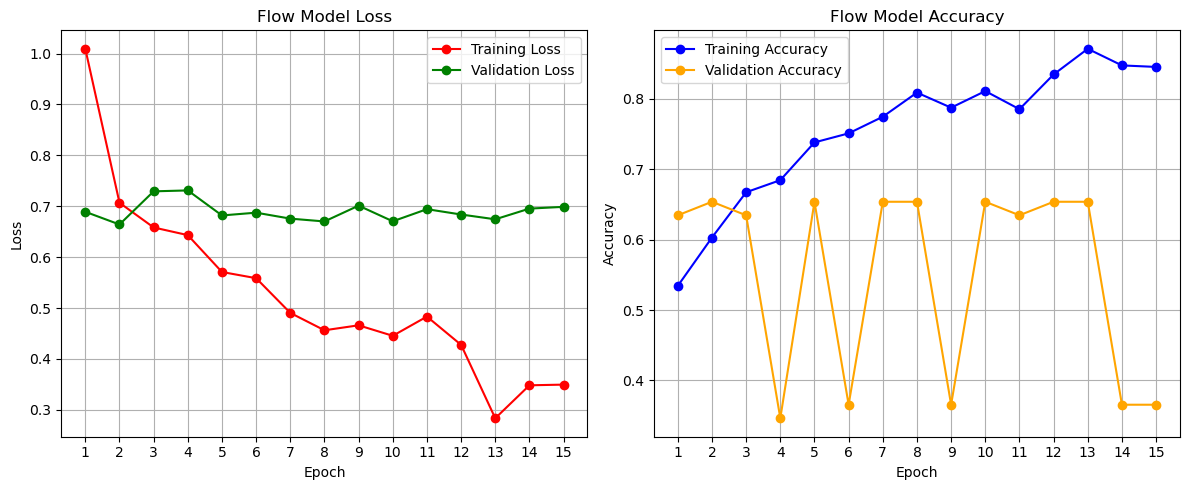

In [21]:
# Separate the losses and accuracies for both training and validation
train_losses = [x[0] for x in train_log]
train_accuracies = [x[1] for x in train_log]

val_losses = [x[0] for x in val_log]
val_accuracies = [x[1] for x in val_log]

# Generate the x-axis values (epochs)
epochs = range(1, num_epochs + 1)

# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='r')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='g')
plt.xticks(epochs)
plt.title('Flow Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o', color='b')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='orange')
plt.xticks(epochs)
plt.title('Flow Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Flow Model Confusion Matrix

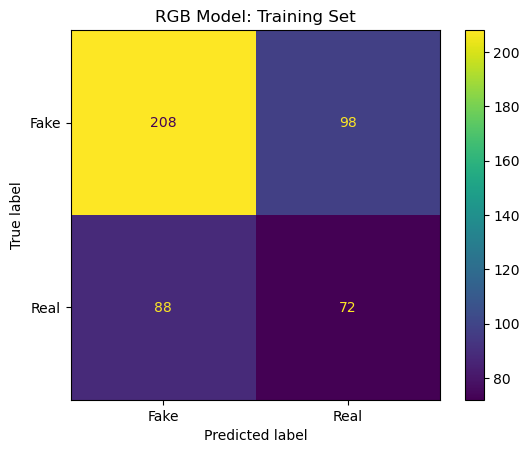

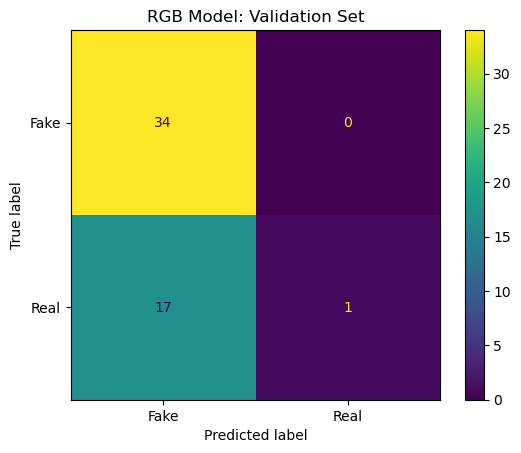

In [28]:
# path = "models/s3d_rgb_best_small_v1.pth"
path = "s3d_rgb_best.pth"

checkpoint = torch.load(path, weights_only=False) #, weights_only=True
# print(checkpoint.keys())
train_cm = checkpoint['train_cm']
val_cm = checkpoint['val_cm']

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = train_cm, display_labels = ['Fake', 'Real'])
cm_display.plot()
cm_display.ax_.set_title('RGB Model: Training Set')
plt.show()

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = val_cm, display_labels = ['Fake', 'Real'])
cm_display.plot()
cm_display.ax_.set_title('RGB Model: Validation Set')
plt.show()

## Flow Dataset

In [2]:
# unfreeze + sgd + scaled + test dataset
dataset_path = "data/Celeb-DF-v2-Flow"
batch_size = 2
epochs = 15
train_log, val_log = train_s3d(dataset_path,batch_size,device,epochs) # 7.8GB 

Training size: 466
Validation size: 52
Input Shape: torch.Size([2, 3, 150, 256, 256])
label Shape: torch.Size([2])
Epoch 1/15
100/233 - Time Taken: 3.12 - train_loss: 0.8252 - train_accuracy: 58.0000%
200/233 - Time Taken: 4.56 - train_loss: 0.8956 - train_accuracy: 51.5000%
233/233 - Time Taken: 9.39 - train_loss: 0.8955 - train_accuracy: 51.9313% - val_loss: 0.7313 - val_accuracy: 63.4615%
Epoch 2/15
100/233 - Time Taken: 4.38 - train_loss: 0.7308 - train_accuracy: 58.5000%
200/233 - Time Taken: 4.25 - train_loss: 0.7535 - train_accuracy: 56.5000%
233/233 - Time Taken: 10.34 - train_loss: 0.7515 - train_accuracy: 55.5794% - val_loss: 0.7333 - val_accuracy: 40.3846%
Epoch 3/15
100/233 - Time Taken: 6.86 - train_loss: 0.6918 - train_accuracy: 61.5000%
200/233 - Time Taken: 2.63 - train_loss: 0.6892 - train_accuracy: 62.2500%
233/233 - Time Taken: 10.42 - train_loss: 0.7043 - train_accuracy: 60.5150% - val_loss: 0.7259 - val_accuracy: 48.0769%
Epoch 4/15
100/233 - Time Taken: 2.55 - tra

### Load Flow Trained Model

In [22]:
path = "models/s3d_flow_last_small_v1.pth"

# replace final layer with new one with appropriate num of classes
# model = s3d(weights=S3D_Weights.DEFAULT)
# model.classifier[1] = nn.Conv3d(1024, 2, kernel_size=1, stride=1)

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

checkpoint = torch.load(path, weights_only=False) #, weights_only=True
print(checkpoint.keys())
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_log = checkpoint['train']
val_log = checkpoint['val']
# train_run = np.array(checkpoint['train_run'])
# train_cm = checkpoint['train_cm']
# val_cm = checkpoint['val_cm']
num_epochs = checkpoint['epoch']

# print(train_log)
# print(val_log)
# print(train_run.shape)
# print(train_run[0])
# print(train_run[1])

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train', 'val', 'train_run', 'train_cm', 'val_cm', 'model'])


### Plot Flow Model Training Results

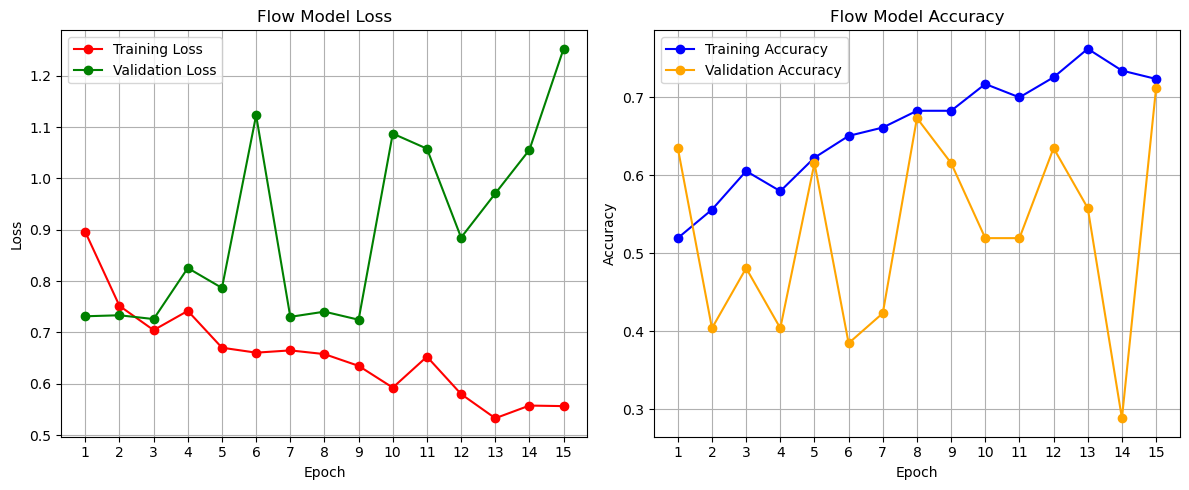

In [23]:
# Separate the losses and accuracies for both training and validation
train_losses = [x[0] for x in train_log]
train_accuracies = [x[1] for x in train_log]

val_losses = [x[0] for x in val_log]
val_accuracies = [x[1] for x in val_log]

# Generate the x-axis values (epochs)
epochs = range(1, num_epochs + 1)

# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='r')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='g')
plt.xticks(epochs)
plt.title('Flow Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o', color='b')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='orange')
plt.xticks(epochs)
plt.title('Flow Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Flow Model Confusion Matrix

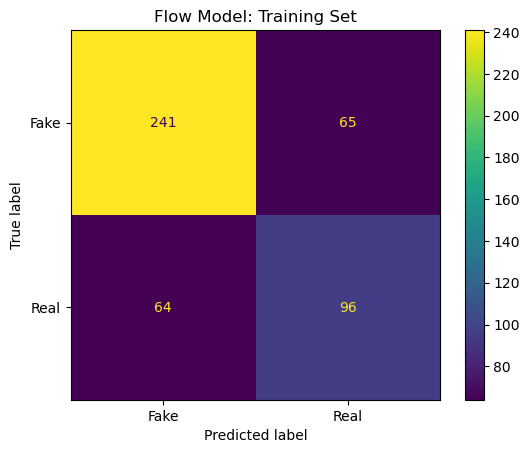

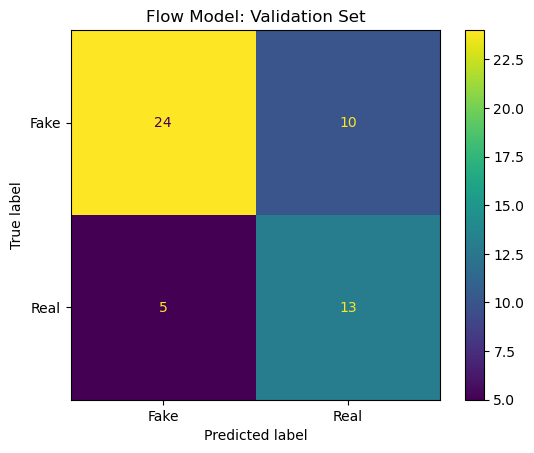

In [24]:
path = "models/s3d_flow_best_small_v1.pth"

checkpoint = torch.load(path, weights_only=False) #, weights_only=True
# print(checkpoint.keys())
train_cm = checkpoint['train_cm']
val_cm = checkpoint['val_cm']

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = train_cm, display_labels = ['Fake', 'Real'])
cm_display.plot()
cm_display.ax_.set_title('Flow Model: Training Set')
plt.show()

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = val_cm, display_labels = ['Fake', 'Real'])
cm_display.plot()
cm_display.ax_.set_title('Flow Model: Validation Set')
plt.show()